In [1]:
# imports from the pyfoomb package
import pyfoomb
print(f'Current package version of {pyfoomb.__name__}: {pyfoomb.__version__}')

from pyfoomb import BioprocessModel
from pyfoomb import ObservationFunction
from pyfoomb import Caretaker
from pyfoomb import Visualization
from pyfoomb import Measurement

C:\Users\hemmerich\AppData\Local\Continuum\miniconda3\envs\pyfoomb-dev\lib\site-packages\assimulo\solvers\odepack.py:701: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  N.array([[0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.],  # 5th order
Could not find GLIMDA.


Current package version of pyfoomb: 2.17.7


In [2]:
from matplotlib import pyplot
import numpy
import pandas

# Set seed of random number generator for reproducibility
numpy.random.seed(123)

We will use a more complex model to demonstrate the use of sensitivities. One needs to take care for the implementation of complex models, as typos etc. will result most likely in integration error at t = 0.000000. So this error indicates that your model implementation and/or parametrization is not consistent.


In [3]:
# Defines the model class
class ComplexKinetic(BioprocessModel):
    
    def rhs(self, t, y):
        # Unpacks the state vector. The states are alphabetically ordered.
        A, B, C, D, E = y
        
        # Unpacks the model parameters.
        kAB = self.model_parameters['kAB']
        kAD = self.model_parameters['kAD']
        kDA = self.model_parameters['kDA']
        kDB = self.model_parameters['kDB']
        kBD = self.model_parameters['kBD']
        kBC = self.model_parameters['kBC']
        kCB = self.model_parameters['kCB']
        kDE = self.model_parameters['kDE']
        kDC = self.model_parameters['kDC']

        # Defines the derivatives.
        dAdt = -kAB*A - kAD*A + kDA*D
        dBdt = kAB*A - kBC*B + kCB*C + kDB*D - kBD*B
        dCdt = kBC*B - kCB*C + kDC*D
        dDdt = kAD*A - kDA*D - kDE*D + kBD*B - kDB*D - kDC*D
        dEdt = kDE*D
        
        # Returns the derivative as list (or numpy array).
        # The order corresponds to the state vector.
        return [dAdt, dBdt, dCdt, dDdt, dEdt]
    
    
# Defines a dictionary for the initial values.
# The keys corresponds to the model states, extended by a 0 (zero).
initial_values = {
    'A0' : 100.0,
    'B0' : 0.0,
    'C0' : 0.0,
    'D0' : 5.0,
    'E0' : 0.0,
}

# Defines a dictionary for the model parameters
# The keys match those variable names used in the model class
model_parameters = {
    'kAB' : 0.2,
    'kAD' : 1e-5,
    'kDA' : 1.5,
    'kDB' : 0.05,
    'kBD' : 5.9,
    'kCB' : 0.1,
    'kBC' : 10.2,
    'kDE' : 2.5,
    'kDC' : 10.0,
}

In [4]:
# Instantiate a Caretaker, which manages the model and its parametrization.
caretaker = Caretaker(
    bioprocess_model_class=ComplexKinetic, 
    model_parameters=model_parameters, 
    initial_values=initial_values,
)

# Runs a forward simulation.
simulation = caretaker.simulate(t=240)

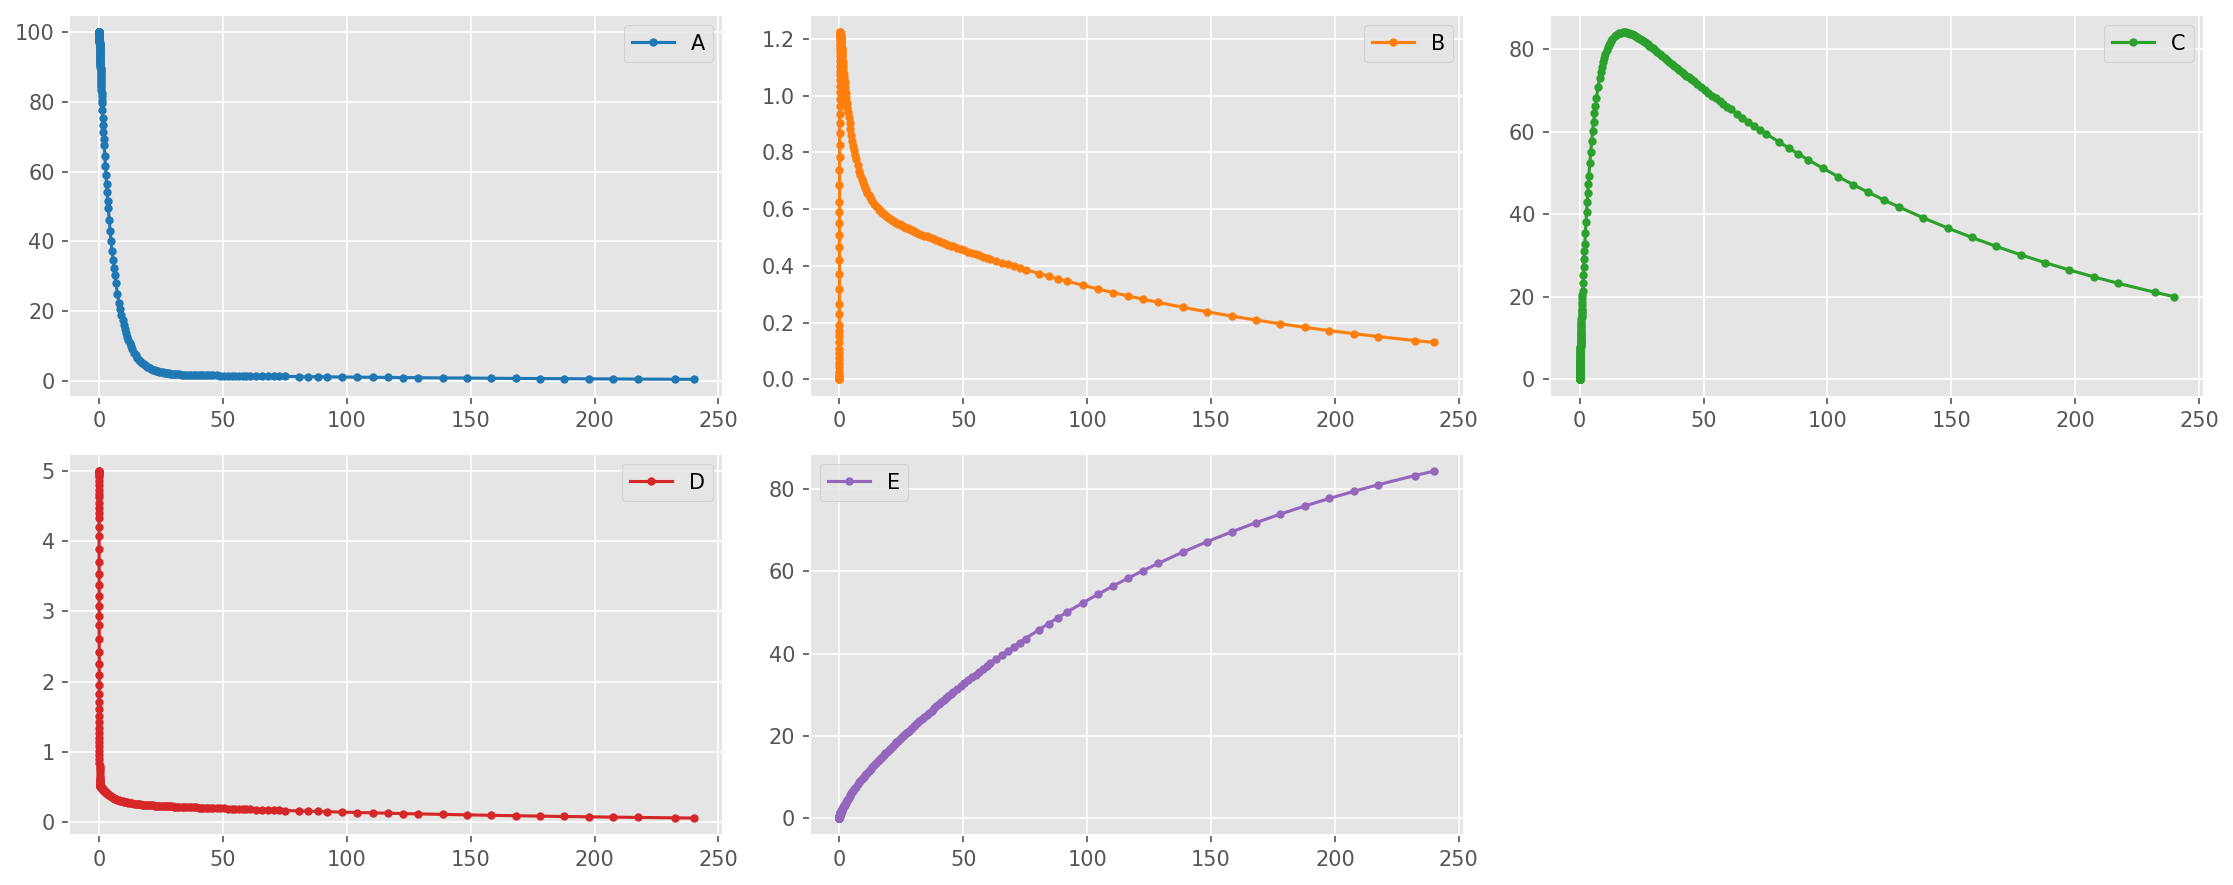

In [5]:
# Show the resulting trajectories
_ = Visualization.show_kinetic_data(simulation)

# Sensitivities

Sensitivities describe how a trajectory changes with a small change in a certain parameter values. The more sensititive a trajectory is w.r.t. a parameter, the more informative this trajectory is w.r.t. this parameter. Since we use dynamic models, the sensitivities change also over time.

In the `pyFOOMB` package, sensitivities are approximated via central different quotient: 
$$s_{i,j}\left(t\right) = \frac{\partial y_i\left(t\right)}{\theta_j} \approx \frac{y_i\left(\theta_j + h, t\right) - y_i\left(\theta_j - h, t\right)}{2\cdot h}$$

The choice of $h$ is crucial to control the approximation error of the sensitivity, according to a rule of thumb, `pyFOOMB` uses a value $h = 10^{-3} \cdot max(1, |p|)$ per default (keyword `rel_h=1e-3` in method `get_sensitivities`).

Sensitivities can be requested for all trajectories w.r.t all parameters, or specific trajectories and specific parameters.

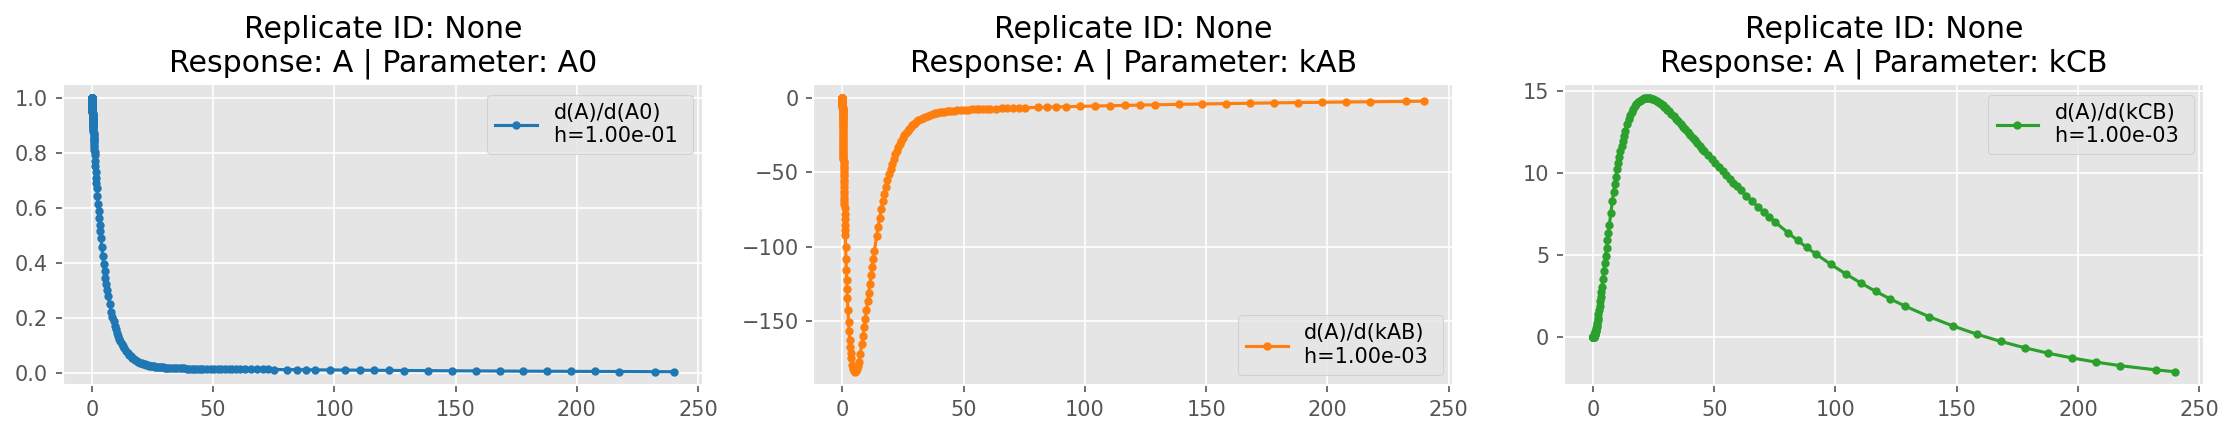

In [6]:
# Get sensitivities for model state `A` w.r.t parameters `kAB`, `A0`, and `kCB`
sensis = caretaker.get_sensitivities(tfinal=240, responses=['A'], parameters=['kAB', 'A0', 'kCB'])
_ = Visualization.show_kinetic_data(sensis)

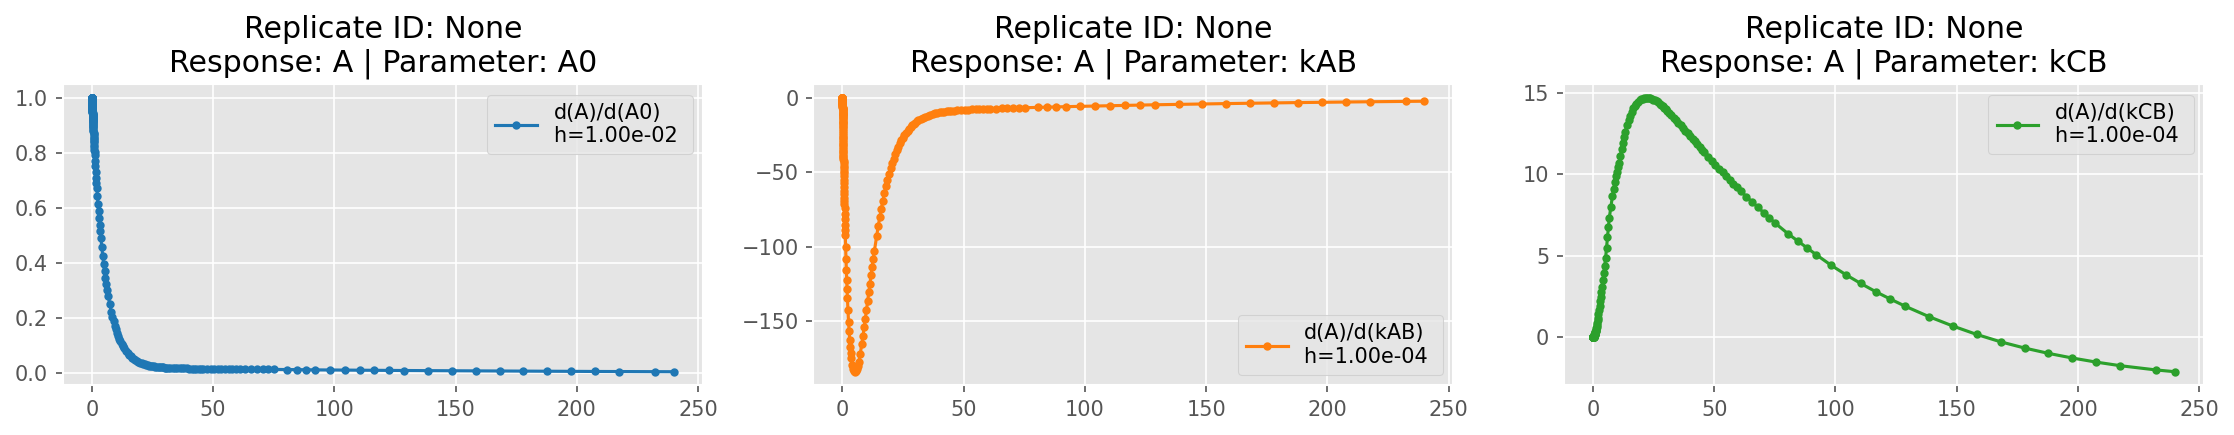

In [7]:
# Get sensitivities using another, non-default value for `rel_h`.
sensis = caretaker.get_sensitivities(tfinal=240, responses=['A'], parameters=['kAB', 'A0', 'kCB'], rel_h=1e-4)
_ = Visualization.show_kinetic_data(sensis)

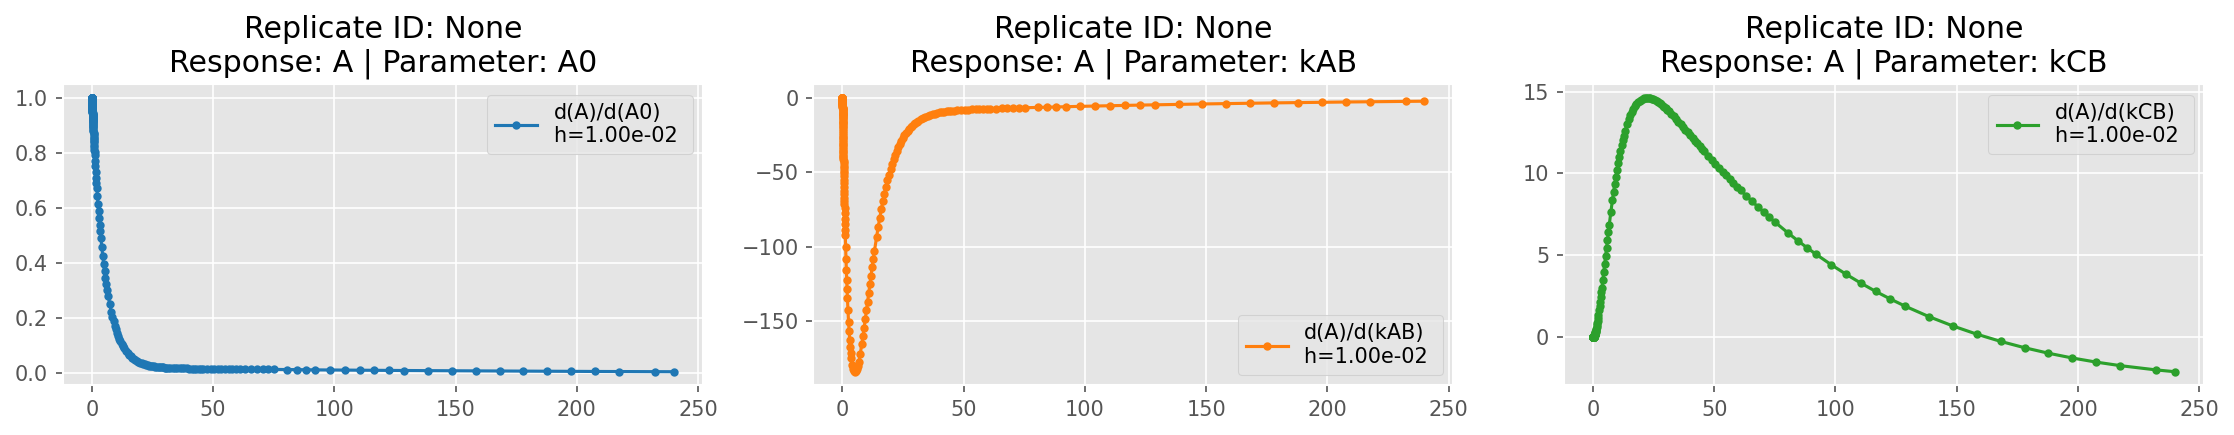

In [8]:
# Also, perturbation of parameter values can be requested on an absolute basis, by using the keyword `abs_h`.
sensis = caretaker.get_sensitivities(tfinal=240, responses=['A'], parameters=['kAB', 'A0', 'kCB'], abs_h=1e-2, rel_h=None)
_ = Visualization.show_kinetic_data(sensis)

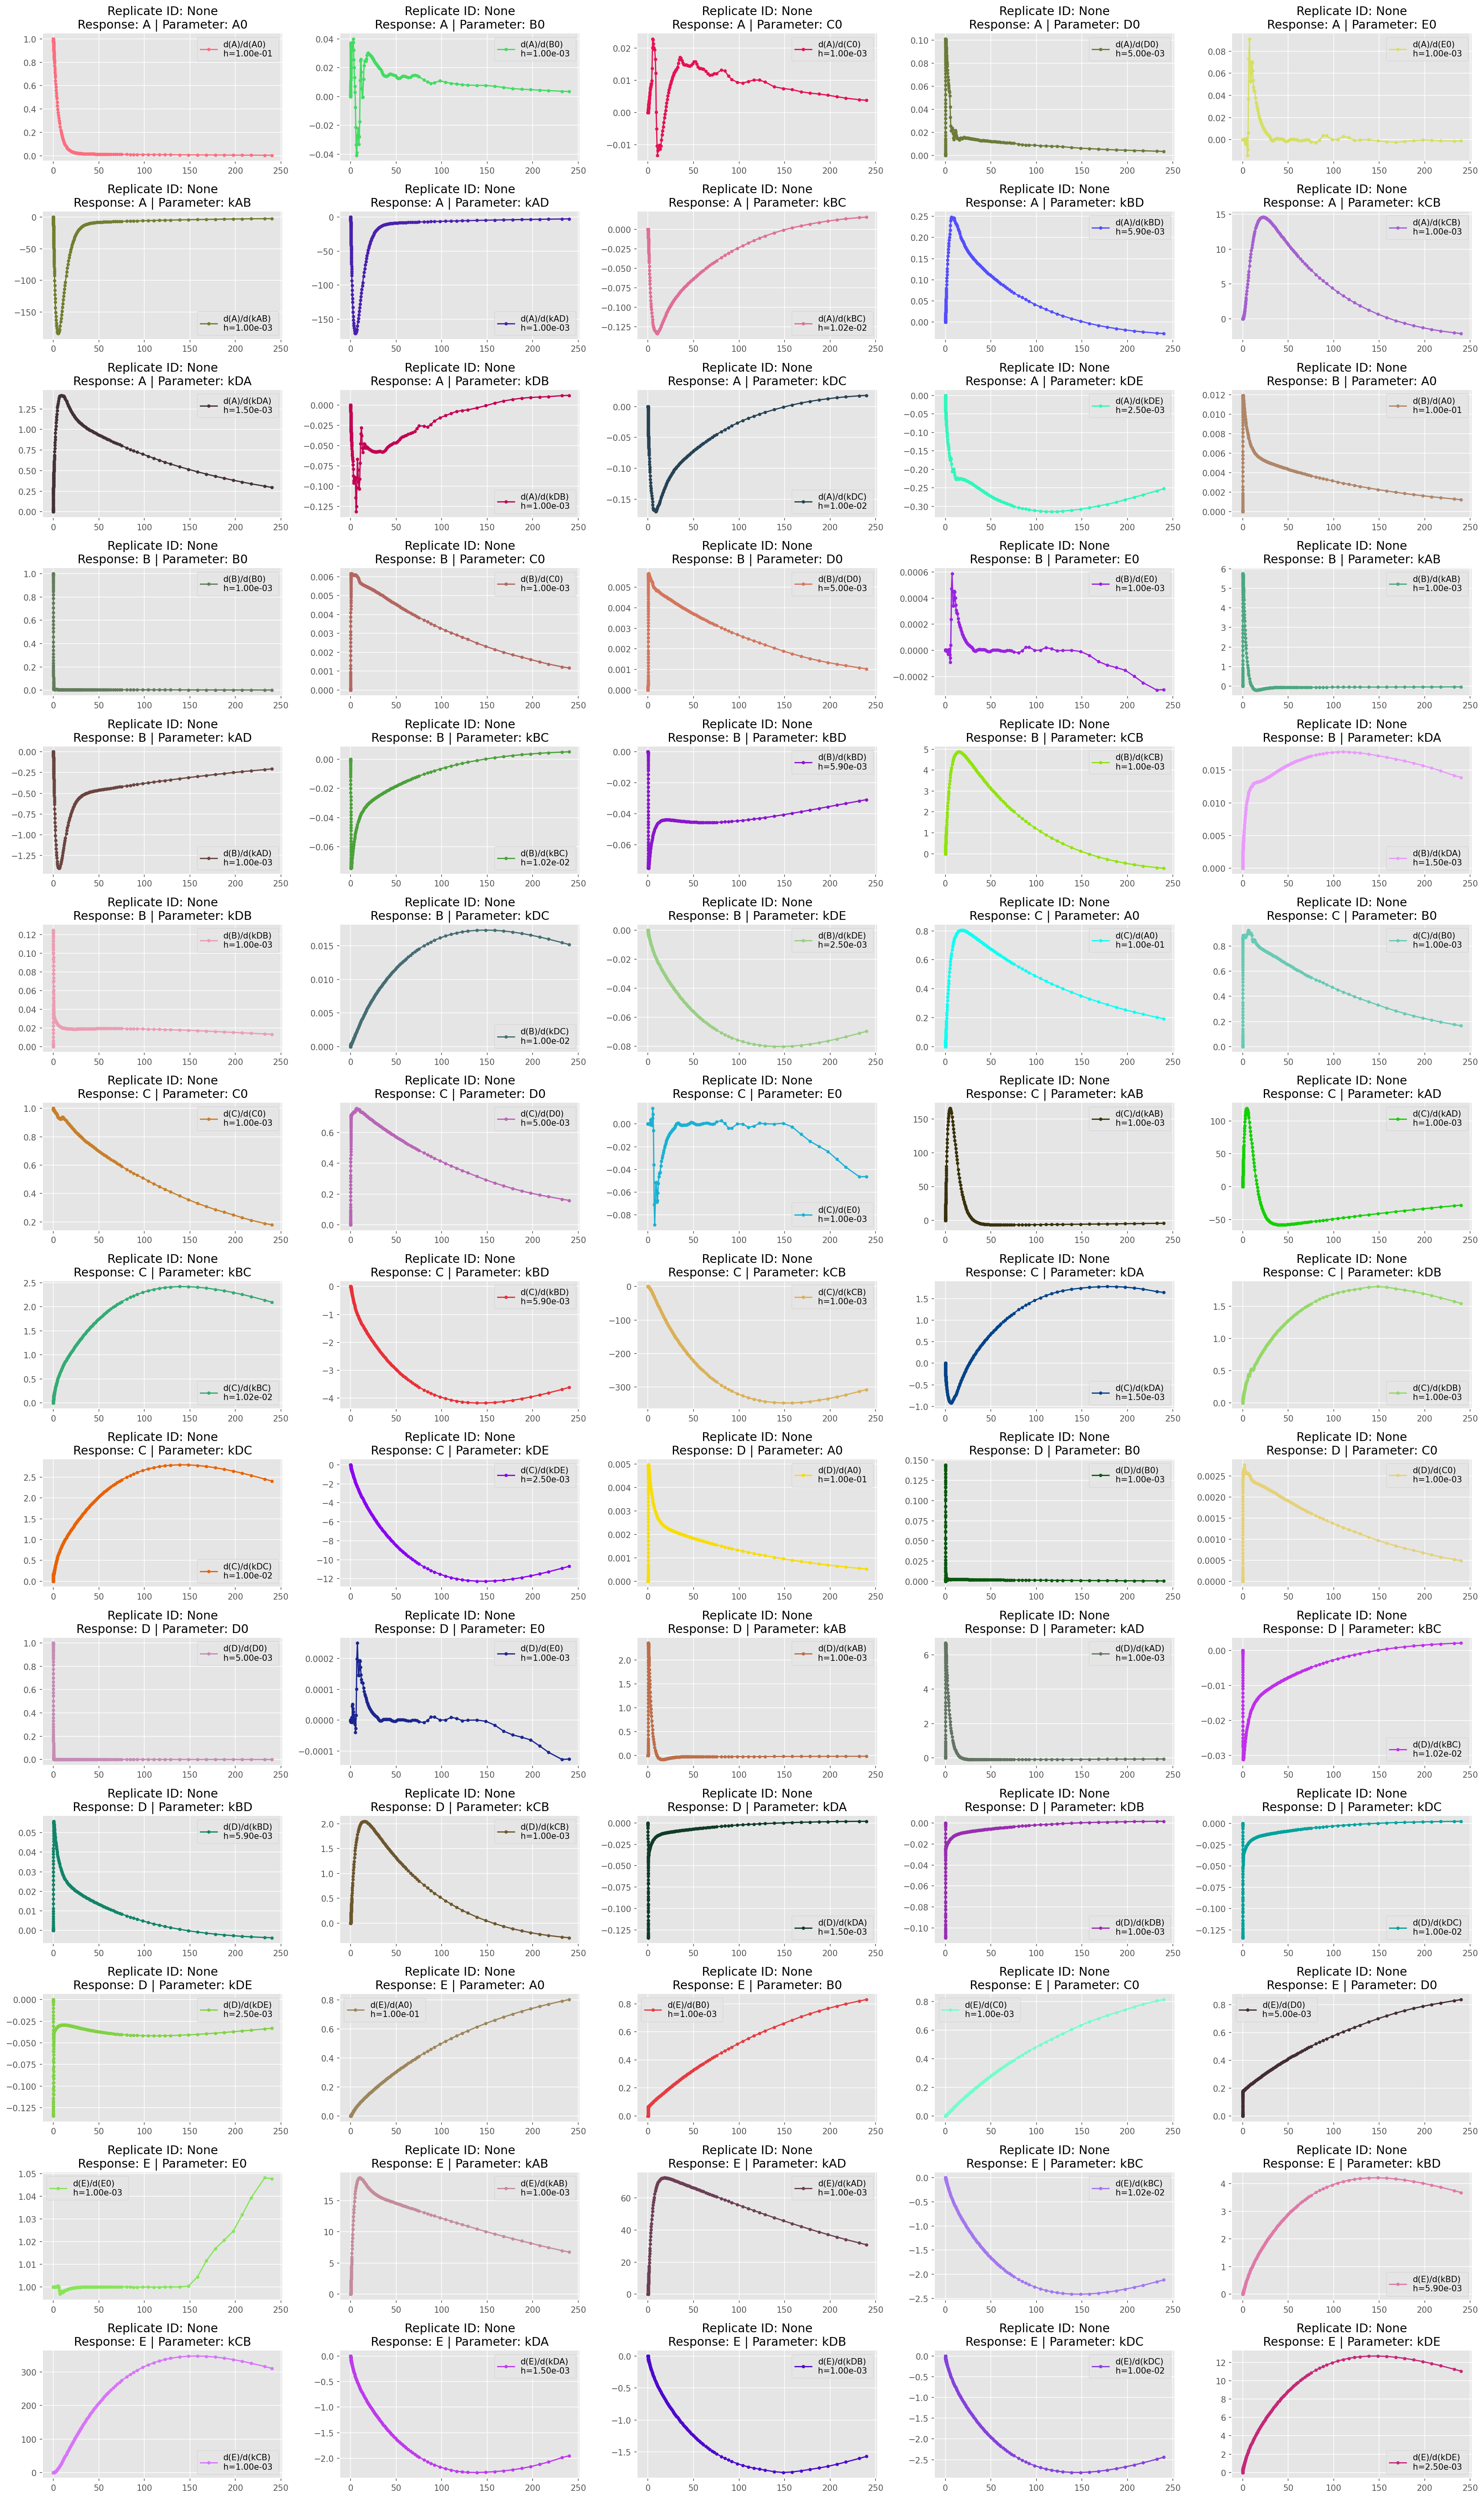

In [9]:
# Get all sensitivities and show them.
# NOTE: This will generate a huge plot
sensis_all = caretaker.get_sensitivities(tfinal=240)
_ = Visualization.show_kinetic_data(sensis_all, ncols=5)